This material was taken from https://www.kaggle.com/learn/machine-learning-explainability. All the credits for the authors.

# Partial Dependence Plots

While feature importance shows what variables most affect predictions, partial dependence plots show how a feature affects predictions.

This is useful to answer questions like:

+ Controlling for all other house features, what impact do longitude and latitude have on home prices? To restate this, how would similarly sized houses be priced in different areas?

+ Are predicted health differences between two groups due to differences in their diets, or due to some other factor?

If you are familiar with linear or logistic regression models, partial dependence plots can be interpreted similarly to the coefficients in those models. Though, partial dependence plots on sophisticated models can capture more complex patterns than coefficients from simple models. If you aren't familiar with linear or logistic regressions, don't worry about this comparison.

We will show a couple examples, explain the interpretation of these plots, and then review the code to create these plots.

## How it Works


Like permutation importance, **partial dependence plots are calculated after a model has been fit**. The model is fit on real data that has not been artificially manipulated in any way.

In our soccer example, teams may differ in many ways. How many passes they made, shots they took, goals they scored, etc. At first glance, it seems difficult to disentangle the effect of these features.

To see how partial plots separate out the effect of each feature, we start by considering a single row of data. For example, that row of data might represent a team that had the ball 50% of the time, made 100 passes, took 10 shots and scored 1 goal.

We will use the fitted model to predict our outcome (probability their player won "man of the match"). But we **repeatedly alter the value for one variable** to make a series of predictions. We could predict the outcome if the team had the ball only 40% of the time. We then predict with them having the ball 50% of the time. Then predict again for 60%. And so on. We trace out predicted outcomes (on the vertical axis) as we move from small values of ball possession to large values (on the horizontal axis).

In this description, we used only a single row of data. Interactions between features may cause the plot for a single row to be atypical. So, we repeat that mental experiment with multiple rows from the original dataset, and we plot the average predicted outcome on the vertical axis.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

data = pd.read_csv('FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

Our first example uses a decision tree, which you can see below. In practice, you'll use more sophistated models for real-world applications.

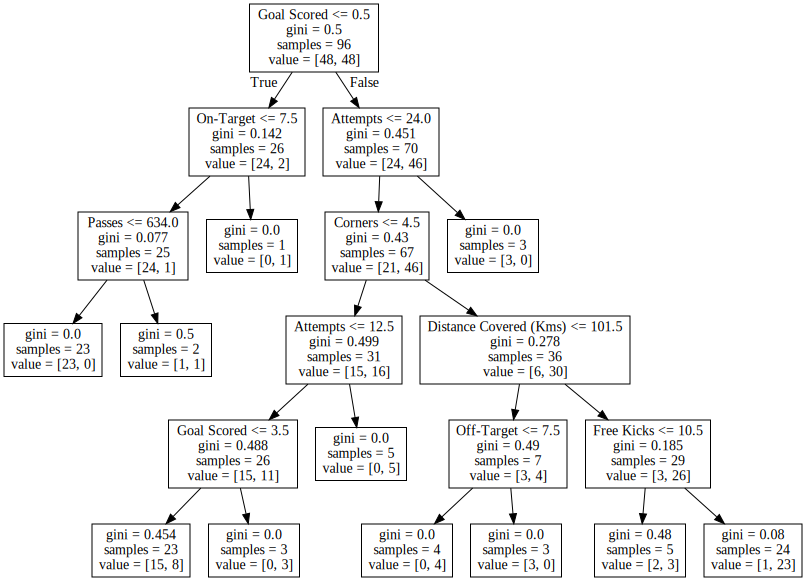

In [2]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names)
graphviz.Source(tree_graph)

As guidance to read the tree:

Leaves with children show their splitting criterion on the top
The pair of values at the bottom show the count of False values and True values for the target respectively, of data points in that node of the tree.

Here is the code to create the Partial Dependence Plot using the [PDPBox library](https://pdpbox.readthedocs.io/en/latest/).

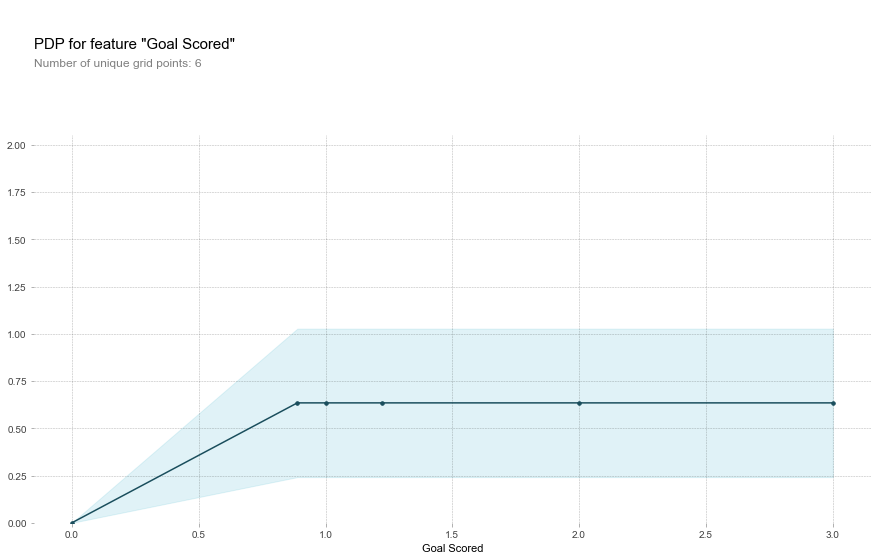

In [4]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature='Goal Scored')

# plot it
pdp.pdp_plot(pdp_goals, 'Goal Scored')
plt.show()

A few items are worth pointing out as you interpret this plot

+ The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
+ A blue shaded area indicates level of confidence

From this particular graph, we see that scoring a goal substantially increases your chances of winning "Man of The Match." But extra goals beyond that appear to have little impact on predictions.

Here is another example plot:

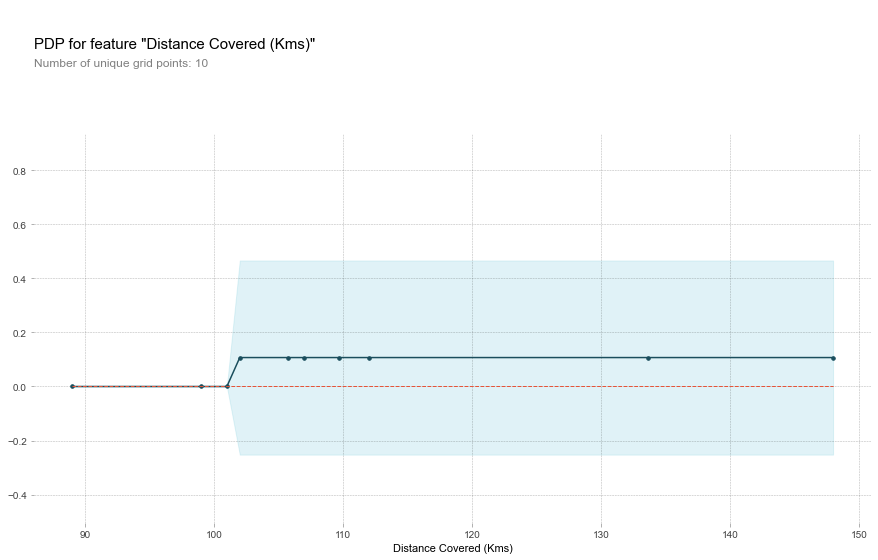

In [6]:
feature_to_plot = 'Distance Covered (Kms)'
pdp_dist = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

This model thinks you are more likely to win Man of the Match if your players run a total of 100km over the course of the game. Though running much more causes lower predictions.

In general, the smooth shape of this curve seems more plausible than the step function from the Decision Tree model. Though this dataset is small enough that we would be careful in how we interpret any model.

## 2D Partial Dependence Plots

If you are curious about interactions between features, 2D partial dependence plots are also useful. An example may clarify this.

We will again use the Decision Tree model for this graph. It will create an extremely simple plot, but you should be able to match what you see in the plot to the tree itself.

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

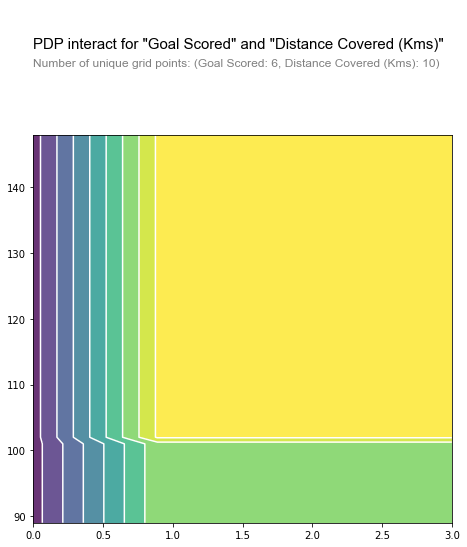

In [7]:
# Similar to previous PDP plot except we use pdp_interact instead of pdp_isolate and pdp_interact_plot instead of pdp_isolate_plot
features_to_plot = ['Goal Scored', 'Distance Covered (Kms)']
inter1  =  pdp.pdp_interact(model=tree_model, dataset=val_X, model_features=feature_names, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

## Exercise 

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Data manipulation code below here
data = pd.read_csv('taxi_fare_prediction/train.csv', nrows=50000)

# Remove data with extreme outlier coordinates or negative fares
data = data.query('pickup_latitude > 40.7 and pickup_latitude < 40.8 and ' +
                  'dropoff_latitude > 40.7 and dropoff_latitude < 40.8 and ' +
                  'pickup_longitude > -74 and pickup_longitude < -73.9 and ' +
                  'dropoff_longitude > -74 and dropoff_longitude < -73.9 and ' +
                  'fare_amount > 0'
                  )

y = data.fare_amount

base_features = ['pickup_longitude',
                 'pickup_latitude',
                 'dropoff_longitude',
                 'dropoff_latitude']

X = data[base_features]


train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
first_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(train_X, train_y)
print("Data sample:")
data.head()

Data sample:


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1


Here is the code to plot the partial dependence plot for pickup_longitude. Run the following cell.

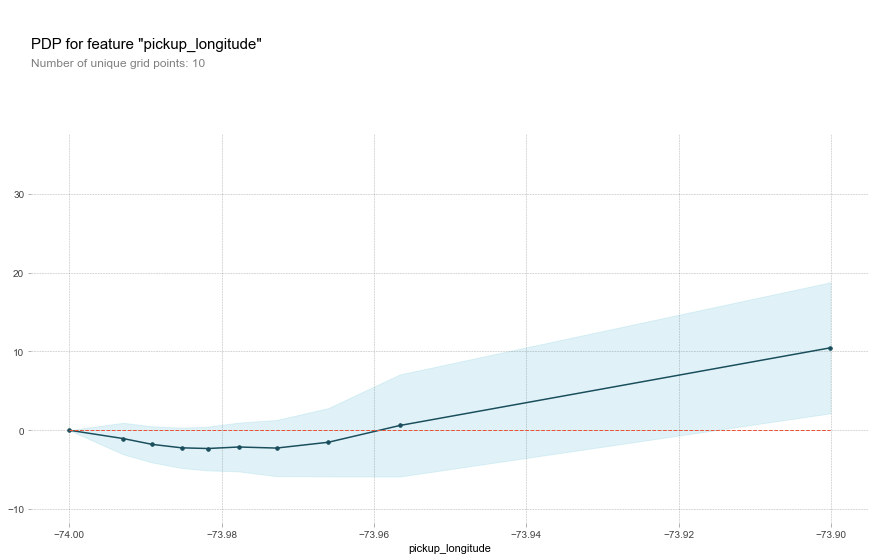

In [9]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

feat_name = 'pickup_longitude'
pdp_dist = pdp.pdp_isolate(model=first_model, dataset=val_X, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

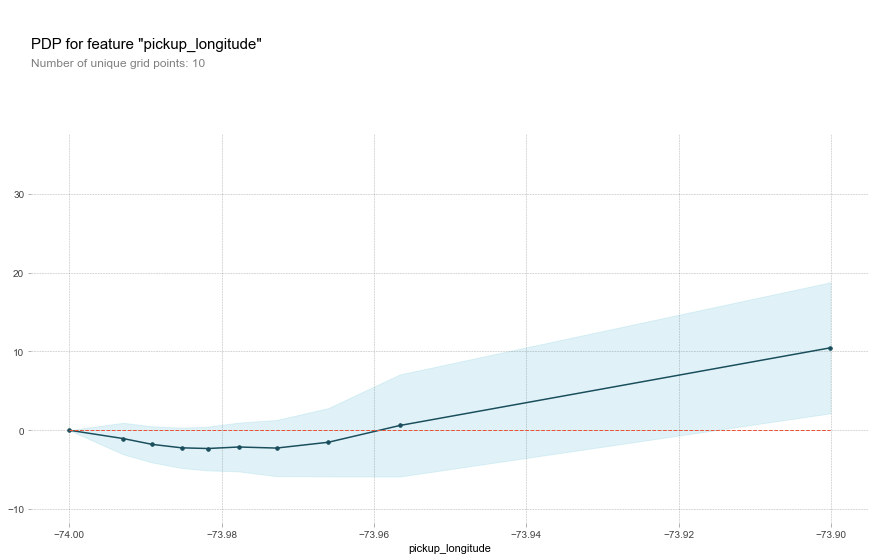

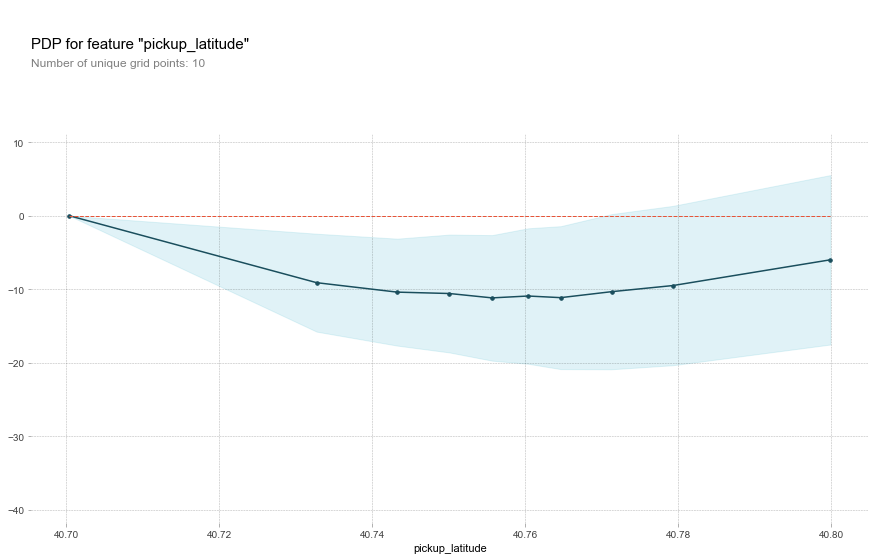

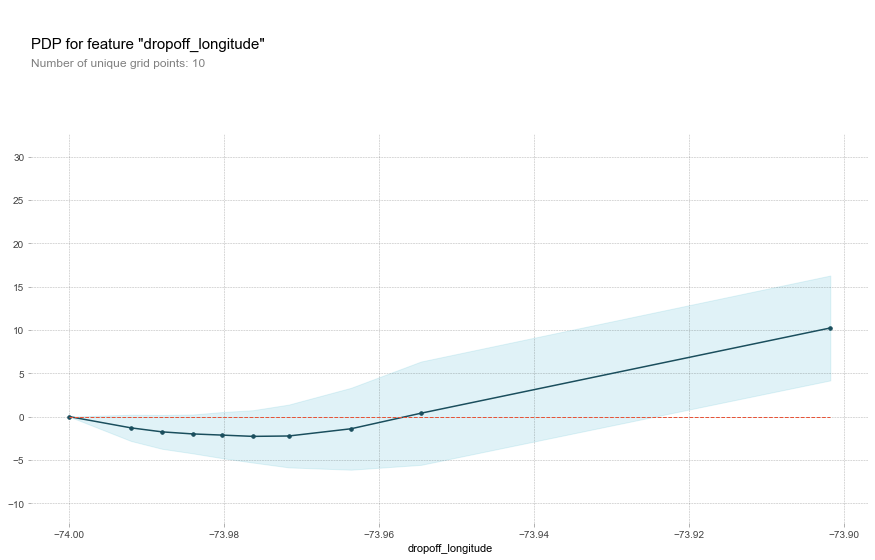

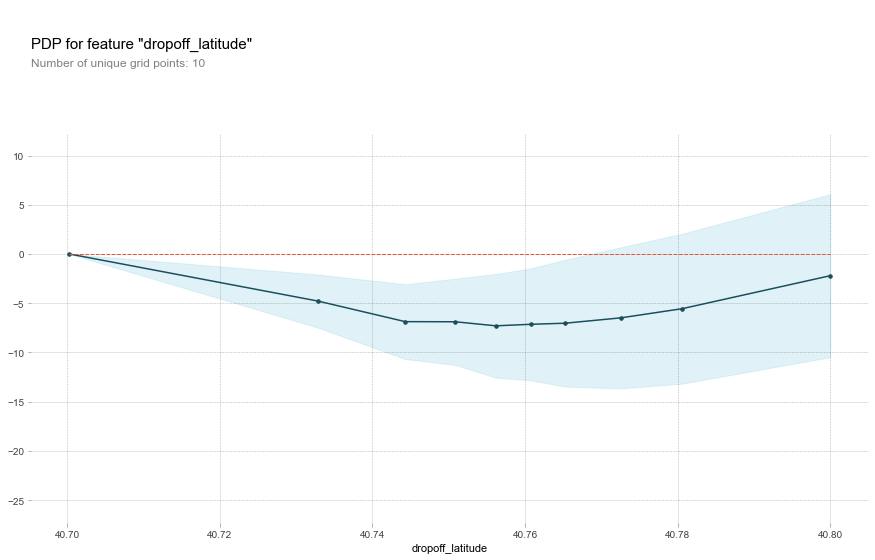

In [10]:
for feat_name in base_features:
    pdp_dist = pdp.pdp_isolate(model=first_model, dataset=val_X, model_features=base_features, feature=feat_name)
    pdp.pdp_plot(pdp_dist, feat_name)
    plt.show()

Do the shapes match your expectations for what shapes they would have? Can you explain the shape now that you've seen them?

We have a sense from the permutation importance results that distance is the most important determinant of taxi fare.

This model didn't include distance measures (like absolute change in latitude or longitude) as features, so coordinate features (like pickup_longitude) capture the effect of distance. Being picked up near the center of the longitude values lowers predicted fares on average, because it means shorter trips (on average).

For the same reason, we see the general U-shape in all our partial dependence plots.

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

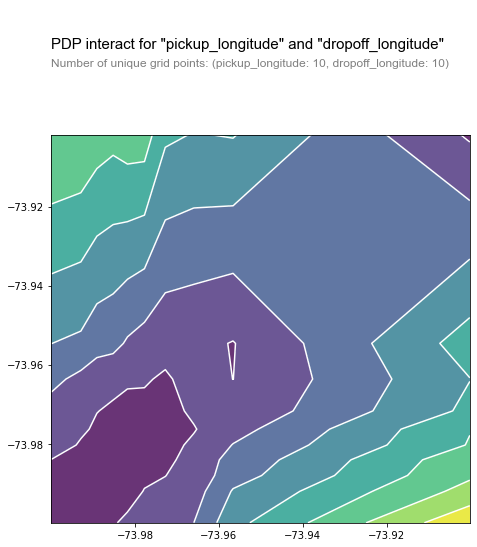

In [11]:
features_to_plot = ['pickup_longitude', 'dropoff_longitude']
inter1  =  pdp.pdp_interact(model=first_model, dataset=val_X, model_features=base_features, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

You should expect the plot to have contours running along a diagonal. We see that to some extent, though there are interesting caveats.

We expect the diagonal contours because these are pairs of values where the pickup and dropoff longitudes are nearby, indicating shorter trips (controlling for other factors).

As you get further from the central diagonal, we should expect prices to increase as the distances between the pickup and dropoff longitudes also increase.

The surprising feature is that prices increase as you go further to the upper-right of this graph, even staying near that 45-degree line.

This could be worth further investigation, though the effect of moving to the upper right of this graph is small compared to moving away from that 45-degree line.

Consider a ride starting at longitude -73.92 and ending at longitude -74. Using the graph from the last question, estimate how much money the rider would have saved if they'd started the ride at longitude -73.98 instead?

In [27]:
24 -9

15

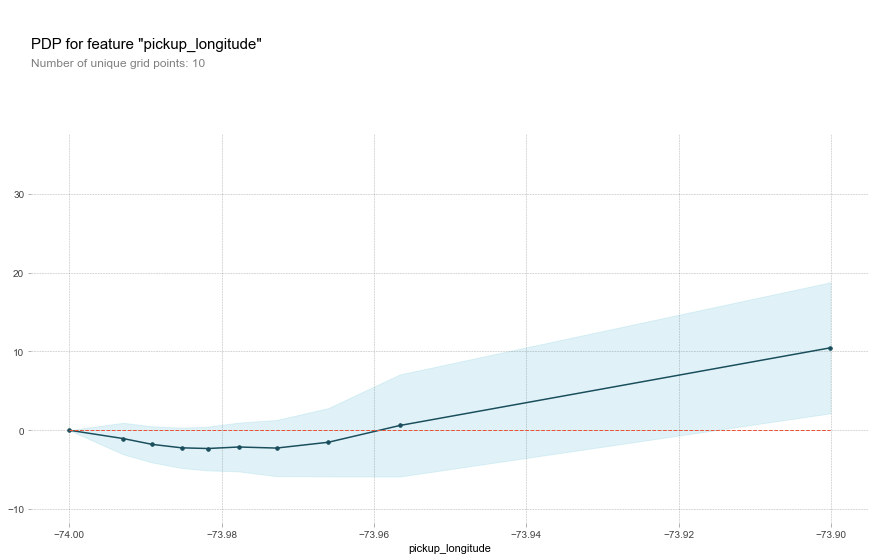

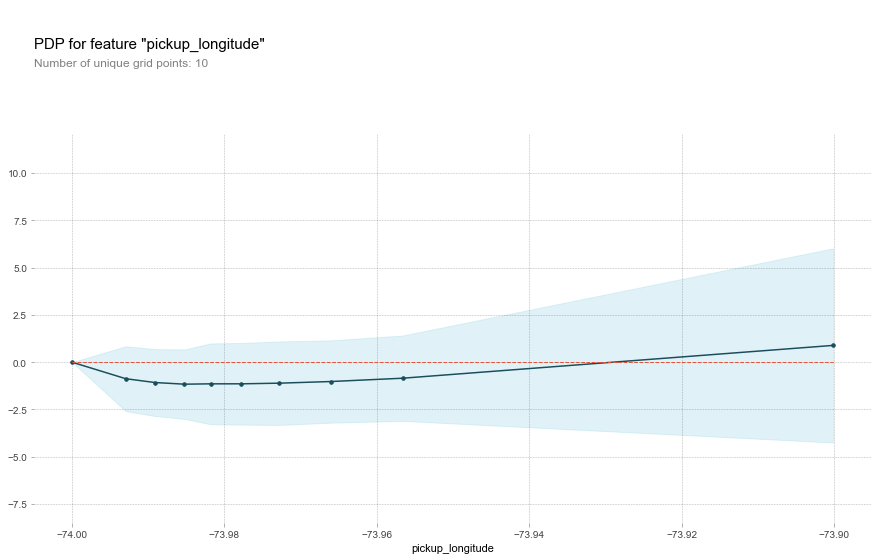

In [28]:
# This is the PDP for pickup_longitude without the absolute difference features. Included here to help compare it to the new PDP you create
feat_name = 'pickup_longitude'
pdp_dist_original = pdp.pdp_isolate(model=first_model, dataset=val_X, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist_original, feat_name)
plt.show()



# create new features
data['abs_lon_change'] = abs(data.dropoff_longitude - data.pickup_longitude)
data['abs_lat_change'] = abs(data.dropoff_latitude - data.pickup_latitude)

features_2  = ['pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'abs_lat_change',
               'abs_lon_change']

X = data[features_2]
new_train_X, new_val_X, new_train_y, new_val_y = train_test_split(X, y, random_state=1)
second_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(new_train_X, new_train_y)

feat_name = 'pickup_longitude'
pdp_dist = pdp.pdp_isolate(model=second_model, dataset=new_val_X, model_features=features_2, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()


The biggest difference is that the partial dependence plot became much smaller. The the lowest vertical value is about  15𝑏𝑒𝑙𝑜𝑤𝑡ℎ𝑒ℎ𝑖𝑔ℎ𝑒𝑠𝑡𝑣𝑒𝑟𝑡𝑖𝑐𝑎𝑙𝑣𝑎𝑙𝑢𝑒𝑖𝑛𝑡ℎ𝑒𝑡𝑜𝑝𝑐ℎ𝑎𝑟𝑡,𝑤ℎ𝑒𝑟𝑒𝑎𝑠𝑡ℎ𝑖𝑠𝑑𝑖𝑓𝑓𝑒𝑟𝑒𝑛𝑐𝑒𝑖𝑠𝑜𝑛𝑙𝑦𝑎𝑏𝑜𝑢𝑡 3 in the chart you just created. In other words, once you control for absolute distance traveled, the pickup_longitude has only a very small impact on predictions.

The code cell below does the following:

1. Creates two features, `X1` and `X2`, having random values in the range [-2, 2].
2. Creates a target variable `y`, which is always 1.
3. Trains a `RandomForestRegressor` model to predict `y` given `X1` and `X2`.
4. Creates a PDP plot for `X1` and a scatter plot of `X1` vs. `y`.

Do you have a prediction about what the PDP plot will look like? Run the cell to find out.

Modify the initialization of `y` so that our PDP plot has a positive slope in the range [-1,1], and a negative slope everywhere else. (Note: *you should only modify the creation of `y`, leaving `X1`, `X2`, and `my_model` unchanged.*)

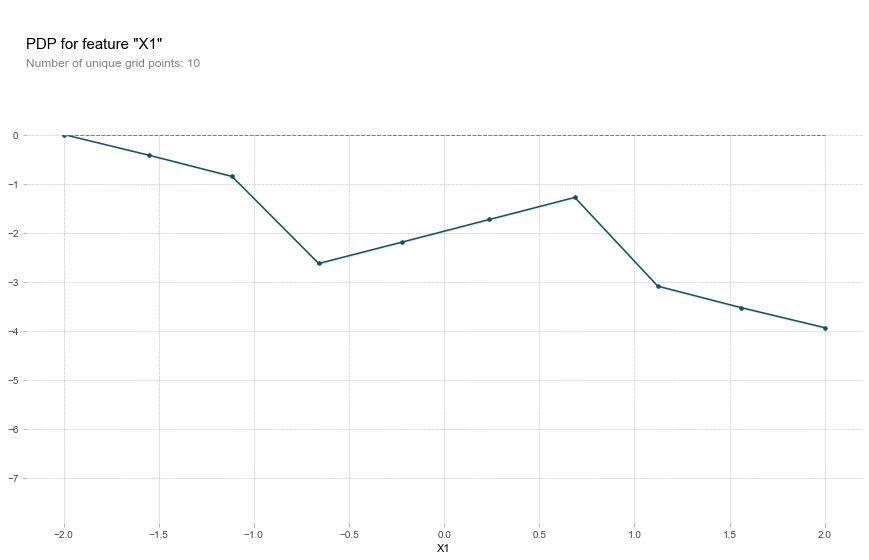

In [29]:
import numpy as np
from numpy.random import rand

n_samples = 20000

# Create array holding predictive feature
X1 = 4 * rand(n_samples) - 2
X2 = 4 * rand(n_samples) - 2
# Create y. you should have X1 and X2 in the expression for y
y =  -2 * X1 * (X1<-1) + X1 - 2 * X1 * (X1>1) - X2

# create dataframe because pdp_isolate expects a dataFrame as an argument
my_df = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})
predictors_df = my_df.drop(['y'], axis=1)

my_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(predictors_df, my_df.y)

pdp_dist = pdp.pdp_isolate(model=my_model, dataset=my_df, model_features=['X1', 'X2'], feature='X1')

# visualize your results
pdp.pdp_plot(pdp_dist, 'X1')
plt.show()
